# Computer Systems 2016/17

### Practice 2 - Non personalized recommenders

#### We will use the Movielens 100k dataset. We download it and uncompress the file we need

In [1]:
from urllib.request import urlretrieve
import zipfile

import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "ml-100k.zip")

('ml-100k.zip', <http.client.HTTPMessage at 0x7f58a28b45f8>)

In [3]:
dataFile = zipfile.ZipFile("ml-100k.zip")

URM_path = dataFile.extract("ml-100k/u.data")
URM = sc.textFile(URM_path)

#### Let's take a look at the data

In [4]:
print ("The number of intereactions is {}".format(URM.count()))

URM.take(10)

The number of intereactions is 100000


['196\t242\t3\t881250949',
 '186\t302\t3\t891717742',
 '22\t377\t1\t878887116',
 '244\t51\t2\t880606923',
 '166\t346\t1\t886397596',
 '298\t474\t4\t884182806',
 '115\t265\t2\t881171488',
 '253\t465\t5\t891628467',
 '305\t451\t3\t886324817',
 '6\t86\t3\t883603013']

### We split each row to separate user, item, rating and timestamp. We do that with a custom function creating a tuple for each interaction

In [5]:
def rowSplit (rowString):
    split = rowString.split("\t")
    result = tuple(split)
    return result

URM_tuple = URM.map(rowSplit)

URM_tuple.take(10)

[('196', '242', '3', '881250949'),
 ('186', '302', '3', '891717742'),
 ('22', '377', '1', '878887116'),
 ('244', '51', '2', '880606923'),
 ('166', '346', '1', '886397596'),
 ('298', '474', '4', '884182806'),
 ('115', '265', '2', '881171488'),
 ('253', '465', '5', '891628467'),
 ('305', '451', '3', '886324817'),
 ('6', '86', '3', '883603013')]

### Now we can display some statistics

In [6]:
itemList = URM_tuple.map(lambda x: x[1])
itemList_distinct = itemList.distinct()

userList = URM_tuple.map(lambda x: x[0])
userList_distinct = userList.distinct()

numInteractions = URM_tuple.count()
numUsers = userList_distinct.count()
numItems = itemList_distinct.count()


print ("Number of items {}, Number of users {}".format(numItems, numUsers))
print ("Average interactions per user {}".format(numInteractions/numUsers))
print ("Average interactions per item {}".format(numInteractions/numItems))

print ("Sparsity {:.2f} %".format((1-float(numInteractions)/(numItems*numUsers))*100))


Number of items 1682, Number of users 943
Average interactions per user 106.04453870625663
Average interactions per item 59.45303210463734
Sparsity 93.70 %


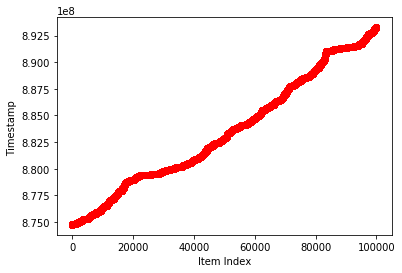

In [7]:
import matplotlib.pyplot as pyplot

timestamps = URM_tuple.map(lambda x: x[3]).takeOrdered(URM_tuple.count(), key=lambda x: +int(x))

pyplot.plot(timestamps, 'ro')
pyplot.ylabel('Timestamp ')
pyplot.xlabel('Item Index')
pyplot.show()

## Top Popular recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions
#### We could have used also countByValue()

In [8]:
URM_training, URM_test = URM_tuple.randomSplit([0.6, 0.4])

print("Train tuples {}, test tuples {}".format(URM_training.count(), URM_test.count()))

Train tuples 60111, test tuples 39889


In [9]:
itemPopularity = URM_training.map(lambda x: (x[1],1))

itemPopularity.take(10)

[('242', 1),
 ('51', 1),
 ('451', 1),
 ('86', 1),
 ('257', 1),
 ('29', 1),
 ('274', 1),
 ('1042', 1),
 ('144', 1),
 ('118', 1)]

In [10]:
itemPopularity_wrong = itemPopularity.reduceByKey(lambda x,y : x+1)

itemPopularity_wrong.take(10)

[('1137', 12),
 ('190', 35),
 ('263', 9),
 ('110', 11),
 ('695', 6),
 ('473', 34),
 ('883', 5),
 ('365', 15),
 ('1117', 6),
 ('1592', 2)]

In [11]:
print ("The total number of interactions is {}, the train data size is {}"
       .format(itemPopularity_wrong.map(lambda x: x[1]).sum(),
              URM_training.count()))

The total number of interactions is 31708, the train data size is 60111


### Be careful wit the reductions, in a sequential context we would use x+1, here it's x+y because reductions will be performed in parallel some elements will be be themselves the result of a reduction on another subset of the data

In [12]:
itemPopularity = itemPopularity.reduceByKey(lambda x,y : x+y)

itemPopularity.take(10)

[('1137', 20),
 ('190', 72),
 ('263', 12),
 ('110', 20),
 ('695', 8),
 ('473', 78),
 ('883', 7),
 ('365', 29),
 ('1117', 11),
 ('1592', 4)]

In [13]:
print ("The total number of interactions is {}, the train data size is {}"
       .format(itemPopularity.map(lambda x: x[1]).sum(),
              URM_training.count()))

The total number of interactions is 60111, the train data size is 60111


In [14]:
itemPopularity_sorted = itemPopularity.sortBy(lambda x: x[1], ascending=False)

itemPopularity_sorted.take(10)

[('50', 355),
 ('258', 303),
 ('100', 296),
 ('286', 292),
 ('181', 292),
 ('288', 288),
 ('294', 286),
 ('1', 275),
 ('121', 267),
 ('174', 264)]

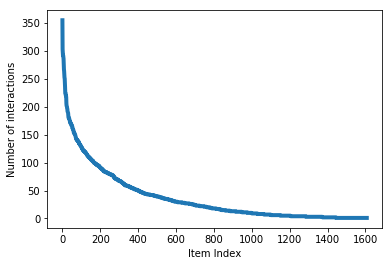

In [15]:
pyplot.plot(itemPopularity_sorted.map(lambda x:x[1]).collect(), linewidth=4.0)
pyplot.ylabel('Number of interactions')
pyplot.xlabel('Item Index')
pyplot.show()

#### There is a huge gap between popular and unpopular items

In [16]:
tenPercent = int(numItems/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(itemPopularity_sorted.map(lambda x:x[1]).mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(sc.parallelize(itemPopularity_sorted.map(lambda x:x[1]).
                            takeOrdered(tenPercent, key=lambda x: -x)).mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(sc.parallelize(itemPopularity_sorted.map(lambda x:x[1]).
                            takeOrdered(tenPercent, key=lambda x: +x)).mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(sc.parallelize(itemPopularity_sorted.map(lambda x:x[1]).
                            collect()[int(numItems*0.45):int(numItems*0.55)]).mean()))

Average per-item interactions over the whole dataset 37.38
Average per-item interactions for the top 10% popular items 152.85
Average per-item interactions for the least 10% popular items 1.03
Average per-item interactions for the median 10% popular items 15.95


### Now that we have the items sorted with respect to the number of interactions, we can build the recommending function

### We will recommend always the most popular items, except those the user has already seen

In [17]:
numberOfItemsToRecommend = 5;

def recommendTopPop(user_id, removeSeen=True):
    
    if(removeSeen):

        seenItems = URM_training.filter(lambda x: x[0] == user_id).map(lambda x:x[1]).collect()

        unseenItems = itemPopularity_sorted.filter(lambda x: x[0] not in seenItems)
        
        recommendedList = unseenItems.takeOrdered(numberOfItemsToRecommend, lambda x:-x[1])
        
    else:
        recommendedList = itemPopularity.takeOrdered(numberOfItemsToRecommend, lambda x:-x[1])
    
    return sc.parallelize(recommendedList).map(lambda x: x[0]).collect()

In [18]:
userId = "42"

recommendTopPop(userId, removeSeen=False)

['50', '258', '100', '286', '181']

In [19]:
recommendTopPop(userId, removeSeen=True)

['50', '258', '100', '286', '288']

#### What if we want to perform recommendations for all the users in our test set?
#### Since we have a custom function we could just map it onto the test set, however...

In [20]:
userList_test = URM_test.map(lambda x: x[0])

userList_test.map(recommendTopPop)


AttributeError: 'Exception' object has no attribute 'message'

#### We get this error
##### Exception: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPARK-5063.

#### The problem is that we are calling the function on an RDD (userList_test) and that function needs other RDDs (itemPopularity_sorted). Nesting RDDs is not permitted

#### To solve this we have two options:
##### - Cycle the test users in a for loop or use a parallel pool to run the function in parallel across multiple users
##### - Rewrite the function in order for it to be RDD-free

### We precompute whatever we can and then we collect it in a differend data structure.
### For itemPopularity we just use a list, since it keeps the ordering, for userSeenItems we use a map/dictionary which is a (key, value) data structure

In [21]:
userSeenItems = URM_training.map(lambda x: (x[0], [x[1]])).reduceByKey(lambda x,y : x + y)

userSeenItems_dict = userSeenItems.collectAsMap()

user_id = "42"
print("User {} saw {} items, some of them are: {}".
      format(user_id, len(userSeenItems_dict[user_id]), userSeenItems_dict[user_id][0:10]))

User 42 saw 122 items, some of them are: ['423', '403', '96', '794', '546', '588', '625', '98', '685', '176']


#### We use Numpy as it provides a lot of useful functions. First we get the item IDs, then we order them with respect to their popularity

In [22]:
import numpy as np

itemPopularity_id = np.array(itemPopularity.map(lambda x: x[0]).collect())
itemPopularity_ranking = np.argsort(itemPopularity.map(lambda x: x[1]).collect())[::-1]

itemPopularity_ordered = itemPopularity_id[itemPopularity_ranking]
itemPopularity_ordered

array(['50', '258', '100', ..., '1319', '1675', '1588'], 
      dtype='<U4')

In [23]:
itemPopularity_ranking

array([ 405,   19,  665, ..., 1167, 1159,  143])

### We modify our functions to eliminate all RDDs

In [24]:
numberOfItemsToRecommend = 5;

def recommendTopPopRDDfree(user_id, removeSeen=True):
    
    seenItems = np.array(userSeenItems_dict[userId])

    recommendedList = itemPopularity_ordered
    
    if(removeSeen):
    
        unseen_mask = np.in1d(recommendedList, seenItems, invert=True)
        
        recommendedList = recommendedList[unseen_mask]       
    
    return recommendedList[0:numberOfItemsToRecommend]

### Now we can use the map operation

In [25]:
sc.parallelize(userList.take(10)).map(recommendTopPopRDDfree).collect()

[array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4'), array(['50', '258', '100', '286', '288'], 
       dtype='<U4')]

In [26]:
user_id = "31"
recommendTopPopRDDfree(user_id, removeSeen=True)

array(['50', '258', '100', '286', '288'], 
      dtype='<U4')

In [27]:
recommendTopPopRDDfree(user_id, removeSeen=False)

array(['50', '258', '100', '286', '181'], 
      dtype='<U4')

## Global effects recommender

#### We recommend to all users the highest rated items

#### First we compute the average of all ratings, or global average

In [28]:
globalAverage = URM_tuple.map(lambda x: float(x[2])).mean()

print("The global average is {}".format(globalAverage))

The global average is 3.5298600000000024


#### We subtract the bias to all ratings

In [29]:
URM_tuple_unbiased = URM_tuple.map(lambda x: (x[0], x[1], float(x[2])-globalAverage))
URM_tuple_unbiased.take(10)

[('196', '242', -0.5298600000000024),
 ('186', '302', -0.5298600000000024),
 ('22', '377', -2.5298600000000024),
 ('244', '51', -1.5298600000000024),
 ('166', '346', -2.5298600000000024),
 ('298', '474', 0.47013999999999756),
 ('115', '265', -1.5298600000000024),
 ('253', '465', 1.4701399999999976),
 ('305', '451', -0.5298600000000024),
 ('6', '86', -0.5298600000000024)]

#### Then we compute the average rating for each item, or itemBias
#### The aggregateByKey function requires three parameters, the first is the "zero" element, the second is how to merge new values inside the same partition (y is the next value), the third how to merge different partitions (y is the value-count touple)

In [30]:
sumAndCount = URM_tuple_unbiased.map(lambda x: (x[1], float(x[2]))).\
    aggregateByKey((0,0), lambda x,y: (x[0] + y,    x[1] + 1),
                          lambda x,y: (x[0] + y[0], x[1] + y[1]))

sumAndCount.take(10)

[('1440', (-2.649300000000012, 5)),
 ('190', (75.29735999999971, 124)),
 ('263', (-26.067340000000048, 19)),
 ('110', (-31.425660000000086, 31)),
 ('695', (-7.888180000000034, 13)),
 ('473', (-50.76236000000035, 126)),
 ('883', (-3.8881800000000313, 13)),
 ('17', (-37.74712000000026, 92)),
 ('1117', (-8.067340000000046, 19)),
 ('1592', (0.3506999999999878, 5))]

In [31]:
itemBias = sumAndCount.mapValues(lambda x: x[0]/x[1])

itemBias.take(10)

[('1440', -0.5298600000000024),
 ('190', 0.607236774193546),
 ('263', -1.3719652631578974),
 ('110', -1.0137309677419382),
 ('695', -0.6067830769230795),
 ('473', -0.4028758730158758),
 ('883', -0.29909076923077166),
 ('17', -0.41029478260869845),
 ('1117', -0.42459684210526555),
 ('1592', 0.07013999999999757)]

#### Now we can sort the items by their itemBias and use the same recommendation function as in TopPop

In [32]:
itemBias_sorted = itemBias.sortBy(lambda x: x[1], ascending=False)

itemBias_sorted.take(10)

[('1293', 1.4701399999999978),
 ('1189', 1.4701399999999978),
 ('814', 1.4701399999999976),
 ('1467', 1.4701399999999976),
 ('1201', 1.4701399999999976),
 ('1599', 1.4701399999999976),
 ('1122', 1.4701399999999976),
 ('1536', 1.4701399999999976),
 ('1500', 1.4701399999999976),
 ('1653', 1.4701399999999976)]

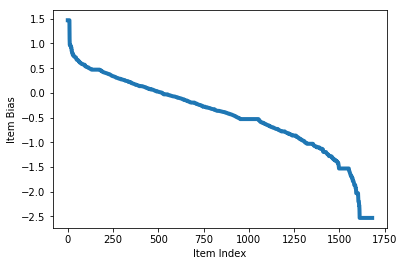

In [33]:
pyplot.plot(itemBias_sorted.map(lambda x:x[1]).collect(), linewidth=4.0)
pyplot.ylabel('Item Bias')
pyplot.xlabel('Item Index')
pyplot.show()

#### If are interested in rating predictions, it is also necessary to take into account the user bias. It is computed the same way as the item bias

In [34]:
sumAndCount = URM_tuple_unbiased.map(lambda x: (x[0], float(x[2]))).\
    aggregateByKey((0,0), lambda x,y: (x[0] + y,    x[1] + 1),
                          lambda x,y: (x[0] + y[0], x[1] + y[1]))

sumAndCount.take(10)

[('190', (-12.261740000000156, 59)),
 ('263', (63.82721999999979, 123)),
 ('110', (-64.47138000000024, 133)),
 ('695', (-9.134680000000095, 38)),
 ('473', (13.454899999999915, 35)),
 ('198', (-45.90466000000044, 181)),
 ('256', (95.31897999999967, 207)),
 ('365', (-8.731880000000144, 58)),
 ('579', (-4.209640000000185, 74)),
 ('50', (0.28335999999993966, 24))]

In [35]:
userBias = sumAndCount.mapValues(lambda x: x[0]/x[1])

userBias.take(10)

[('190', -0.2078261016949179),
 ('263', 0.5189204878048763),
 ('110', -0.48474721804511456),
 ('695', -0.2403863157894762),
 ('473', 0.3844257142857119),
 ('198', -0.2536169060773505),
 ('256', 0.46047816425120613),
 ('365', -0.15054965517241628),
 ('579', -0.056887027027029524),
 ('50', 0.011806666666664153)]

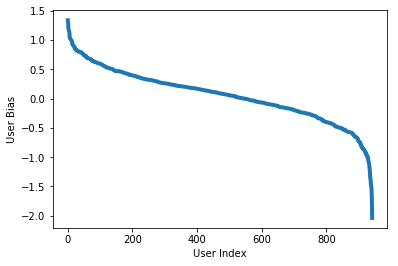

In [36]:
userBias_sorted = userBias.sortBy(lambda x: x[1], ascending=False)

pyplot.plot(userBias_sorted.map(lambda x:x[1]).collect(), linewidth=4.0)
pyplot.ylabel('User Bias')
pyplot.xlabel('User Index')
pyplot.show()